# Necessary Libraries

In [5]:
from easydict import EasyDict as edict
import os
import numpy as np
import matplotlib.pyplot as plt
import mindspore
import mindspore.dataset as ds
from mindspore.dataset.vision import c_transforms as vision
from mindspore import context
import mindspore.nn as nn
from mindspore.train import Model
from mindspore.nn.optim.momentum import Momentum
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor
from mindspore import Tensor
from mindspore.train.serialization import export
from mindspore.train.loss_scale_manager import FixedLossScaleManager
from mindspore.train.serialization import load_checkpoint, load_param_into_net
import mindspore.ops as ops
context.set_context(mode=context.GRAPH_MODE, device_target="CPU")

# Dataset Augmentation
The dataset will be taken from https://ieee-dataport.org/competitions/parasitic-egg-detection-and-classification-microscopic-images, only taking the four classes:
- Ascaris lumbricoides
- Capillaria philippinensis
- Enterobius vermicularis
- Fasciolopsis buski

In [6]:
import mindspore.dataset as ds
import mindspore.dataset.vision.c_transforms as CV
from mindspore import dtype as mstype

train_data_path = '../dataset_train'

classes = {
    'Ascaris lumbricoides': 0,
    'Capillaria philippinensis': 1,
    'Enterobius vermicularis': 2,
    'Fasciolopsis buski': 3,
}

def split_dataset(data_path, split_ratio=0.2):
    """Split the dataset into training and validation sets."""
    full_dataset = ds.ImageFolderDataset(data_path, num_parallel_workers=8, shuffle=True, class_indexing=classes)

    num_samples = full_dataset.get_dataset_size()
    val_size = int(num_samples * split_ratio)
    train_size = num_samples - val_size

    train_dataset, val_dataset = full_dataset.split([train_size, val_size], randomize=True)

    return train_dataset, val_dataset

def create_dataset(data_set, batch_size=18, training=True):
    """Define the dataset transformations and batching."""
    image_size = 224
    mean = [0.485 * 255, 0.456 * 255, 0.406 * 255]
    std = [0.229 * 255, 0.224 * 255, 0.225 * 255]

    if training:
        trans = [
            CV.Decode(),
            CV.Resize(256),
            CV.CenterCrop(image_size),
            CV.RandomHorizontalFlip(prob=0.5),
            CV.Normalize(mean=mean, std=std),
            CV.HWC2CHW() 
        ]
    else:
        trans = [
            CV.Decode(),
            CV.Resize(256),
            CV.CenterCrop(image_size),
            CV.Normalize(mean=mean, std=std),
            CV.HWC2CHW()
        ]

    data_set = data_set.map(operations=trans, input_columns="image", num_parallel_workers=8)
    data_set = data_set.batch(batch_size, drop_remainder=True)
    return data_set


train_dataset, val_dataset = split_dataset(train_data_path, split_ratio=0.2)
dataset_train = create_dataset(train_dataset, training=True)
dataset_val = create_dataset(val_dataset, training=False)

[WARNING] ME(5476:28612,MainProcess):2024-11-12-03:13:43.635.000 [mindspore\dataset\engine\datasets.py:2534] Dataset is shuffled before split.
[WARNING] ME(5476:28612,MainProcess):2024-11-12-03:13:43.636.000 [mindspore\dataset\core\validator_helpers.py:744] 'Decode' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Decode' from mindspore.dataset.vision instead.
[WARNING] ME(5476:28612,MainProcess):2024-11-12-03:13:43.638.000 [mindspore\dataset\core\validator_helpers.py:744] 'Resize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Resize' from mindspore.dataset.vision instead.
[WARNING] ME(5476:28612,MainProcess):2024-11-12-03:13:43.639.000 [mindspore\dataset\core\validator_helpers.py:744] 'CenterCrop' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'CenterCrop' from mindspore.

In [7]:
def create_test_dataset(test_data_path, batch_size=18):
    test_dataset = ds.ImageFolderDataset(test_data_path, num_parallel_workers=8, shuffle=False, class_indexing=classes)
    image_size = 224
    mean = [0.485 * 255, 0.456 * 255, 0.406 * 255]
    std = [0.229 * 255, 0.224 * 255, 0.225 * 255]
    
    trans = [
        CV.Decode(),
        CV.Resize(256),
        CV.CenterCrop(image_size),
        CV.Normalize(mean=mean, std=std),
        CV.HWC2CHW()
    ]
    
    test_dataset = test_dataset.map(operations=trans, input_columns="image", num_parallel_workers=8)
    test_dataset = test_dataset.batch(batch_size, drop_remainder=True)
    
    return test_dataset

test_data_path = '../dataset_test'
dataset_test = create_test_dataset(test_data_path)

[WARNING] ME(5476:28612,MainProcess):2024-11-12-03:13:47.943.000 [mindspore\dataset\core\validator_helpers.py:744] 'Decode' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Decode' from mindspore.dataset.vision instead.
[WARNING] ME(5476:28612,MainProcess):2024-11-12-03:13:47.943.000 [mindspore\dataset\core\validator_helpers.py:744] 'Resize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Resize' from mindspore.dataset.vision instead.
[WARNING] ME(5476:28612,MainProcess):2024-11-12-03:13:47.944.000 [mindspore\dataset\core\validator_helpers.py:744] 'CenterCrop' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'CenterCrop' from mindspore.dataset.vision instead.
[WARNING] ME(5476:28612,MainProcess):2024-11-12-03:13:47.944.000 [mindspore\dataset\core\validator_helpers.py:744] 'Nor

Tensor of image (18, 3, 224, 224)
Labels: [1 1 0 1 1 3 2 3 2 3 0 1 1 1 1 3 1 0]


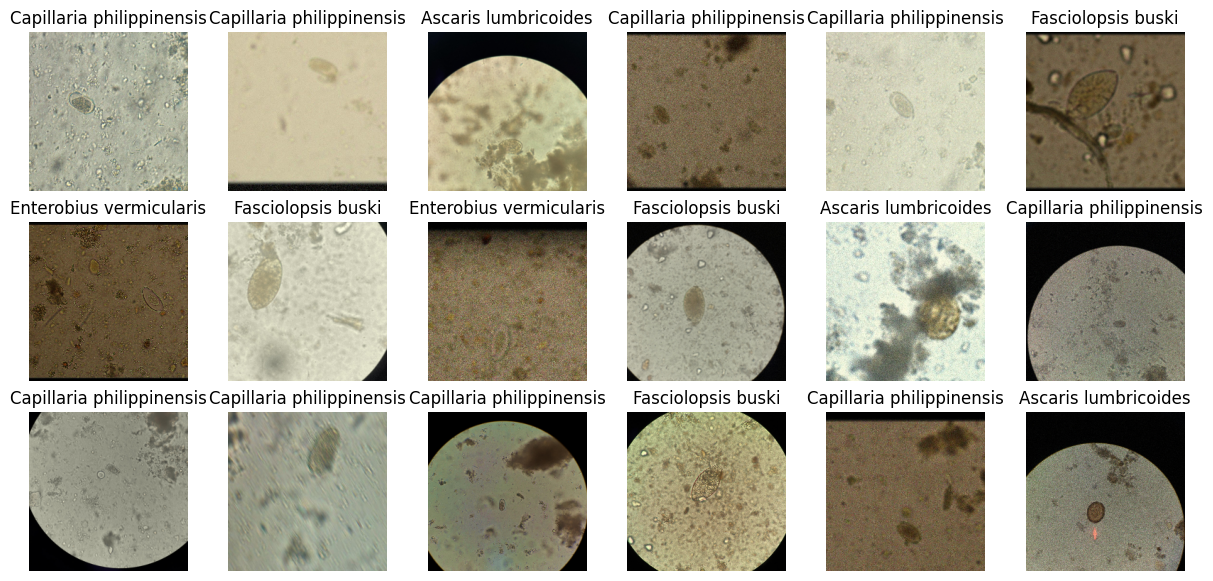

In [8]:
import matplotlib.pyplot as plt
import numpy as np

data = next(dataset_train.create_dict_iterator())
images = data["image"]
labels = data["label"]

print("Tensor of image", images.shape)
print("Labels:", labels)

# class_name corresponds to label. Labels are marked in ascending order of the folder character string.
class_name = {
    0: 'Ascaris lumbricoides',
    1: 'Capillaria philippinensis',
    2: 'Enterobius vermicularis',
    3: 'Fasciolopsis buski'}
plt.figure(figsize=(15, 7))
for i in range(len(labels)):
    # Obtain an image and its label.
    data_image = images[i].asnumpy()
    data_label = labels[i]
    # Process images for display.
    data_image = np.transpose(data_image, (1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    data_image = std * data_image + mean
    data_image = np.clip(data_image, 0, 1)
    # Display the image.
    plt.subplot(3, 6, i + 1)
    plt.imshow(data_image)
    plt.title(class_name[int(labels[i].asnumpy())])
    plt.axis("off")
plt.show()

# Model Building
ResNet50 will be the classification model used to classify the parasitic egg

In [9]:
"""ResNet."""

# Define the weight initialization function.
def _weight_variable(shape, factor=0.01):
    init_value = np.random.randn(*shape).astype(np.float32) * factor
    return Tensor(init_value)

# Define the 3x3 convolution layer functions.
def _conv3x3(in_channel, out_channel, stride=1):
    weight_shape = (out_channel, in_channel, 3, 3)
    weight = _weight_variable(weight_shape)
    return nn.Conv2d(in_channel, out_channel,
        kernel_size=3, stride=stride, padding=0, pad_mode='same', weight_init=weight)

# Define the 1x1 convolution layer functions.
def _conv1x1(in_channel, out_channel, stride=1):
    weight_shape = (out_channel, in_channel, 1, 1)
    weight = _weight_variable(weight_shape)
    return nn.Conv2d(in_channel, out_channel,
        kernel_size=1, stride=stride, padding=0, pad_mode='same', weight_init=weight)
    
# Define the 7x7 convolution layer functions.
def _conv7x7(in_channel, out_channel, stride=1):
    weight_shape = (out_channel, in_channel, 7, 7)
    weight = _weight_variable(weight_shape)
    return nn.Conv2d(in_channel, out_channel,
        kernel_size=7, stride=stride, padding=0, pad_mode='same', weight_init=weight)
    
# Define the Batch Norm layer functions.
def _bn(channel):
    return nn.BatchNorm2d(channel, eps=1e-4, momentum=0.9,
        gamma_init=1, beta_init=0, moving_mean_init=0, moving_var_init=1)

# Define the Batch Norm functions at the last layer.
def _bn_last(channel):
    return nn.BatchNorm2d(channel, eps=1e-4, momentum=0.9,
        gamma_init=0, beta_init=0, moving_mean_init=0, moving_var_init=1)
    
# Define the functions of the fully-connected layers.
def _fc(in_channel, out_channel):
    weight_shape = (out_channel, in_channel)
    weight = _weight_variable(weight_shape)
    return nn.Dense(in_channel, out_channel, has_bias=True, weight_init=weight, bias_init=0)
    
# Construct a residual module.
class ResidualBlock(nn.Cell):
    """
    ResNet V1 residual block definition.
    Args:
    in_channel (int): Input channel.
    out_channel (int): Output channel.
    stride (int): Stride size for the first convolutional layer. Default: 1.
    Returns:
    Tensor, output tensor.
    Examples:
    >>> ResidualBlock(3, 256, stride=2)
    """
    expansion = 4 # In conv2_x--conv5_x, the number of convolution kernels at the first two layers is one fourth of the number of convolution kernels at the third layer (an output channel).

    def __init__(self, in_channel, out_channel, stride=1):
        super(ResidualBlock, self).__init__()
        # The number of convolution kernels at the first two layers is equal to a quarter of the number of convolution kernels at the output channels.
        channel = out_channel // self.expansion
        # Layer 1 convolution
        self.conv1 = _conv1x1(in_channel, channel, stride=1)
        self.bn1 = _bn(channel)
        # Layer 2 convolution
        self.conv2 = _conv3x3(channel, channel, stride=stride)
        self.bn2 = _bn(channel)
        # Layer 3 convolution. The number of convolution kernels is equal to that of output channels.
        self.conv3 = _conv1x1(channel, out_channel, stride=1)
        self.bn3 = _bn_last(out_channel)
        # ReLU activation layer
        self.relu = nn.ReLU()
        self.down_sample = False

        # When the step is not 1 or the number of output channels is not equal to that of input channels, downsampling is performed to adjust the number of channels.
        if stride != 1 or in_channel != out_channel:
            self.down_sample = True
        self.down_sample_layer = None
        # Adjust the number of channels using the 1x1 convolution.
        if self.down_sample:
            self.down_sample_layer = nn.SequentialCell([_conv1x1(in_channel, out_channel, stride), # 1x1 convolution
                                                                _bn(out_channel)]) # Batch Norm
        # Addition operator
        self.add = ops.Add()
    # Construct a residual block.
    def construct(self, x):
        # Input
        identity = x
        # Layer 1 convolution 1x1
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        # Layer 2 convolution 3x3
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        # Layer 3 convolution 1x1
        out = self.conv3(out)
        out = self.bn3(out)
        # Change the network dimension.
        if self.down_sample:
            identity = self.down_sample_layer(identity)
        # Add the residual.
        out = self.add(out, identity)
        # ReLU activation
        out = self.relu(out)
        return out
        
# Construct a residual network.
class ResNet(nn.Cell):
    """
    ResNet architecture.
    Args:
    block (Cell): Block for network.
    layer_nums (list): Numbers of block in different layers.
    in_channels (list): Input channel in each layer.
    out_channels (list): Output channel in each layer.
    strides (list): Stride size in each layer.
    num_classes (int): The number of classes that the training images belong to.
    Returns:
    Tensor, output tensor.
    Examples:
    >>> ResNet(ResidualBlock,
    >>> [3, 4, 6, 3],
    >>> [64, 256, 512, 1024],
    >>> [256, 512, 1024, 2048],
    >>> [1, 2, 2, 2],
    >>> 10)
    """
    # Input parameters: residual block, number of repeated residual blocks, input channel, output channel, stride, and number of image classes
    def __init__(self, block, layer_nums, in_channels, out_channels, strides, num_classes):
        super(ResNet, self).__init__()
        if not len(layer_nums) == len(in_channels) == len(out_channels) == 4:
            raise ValueError("the length of layer_num, in_channels, out_channels list must be 4!")
            
        # Layer 1 convolution; convolution kernels: 7x7, input channels: 3; output channels: 64; step: 2
        self.conv1 = _conv7x7(3, 64, stride=2)
        self.bn1 = _bn(64)
        self.relu = ops.ReLU()
        
        # 3x3 pooling layer; step: 2
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, pad_mode="same")
        
        # conv2_x residual block
        self.layer1 = self._make_layer(block,
                                            layer_nums[0],
                                            in_channel=in_channels[0],
                                            out_channel=out_channels[0],
                                            stride=strides[0])
        
        # conv3_x residual block
        self.layer2 = self._make_layer(block,
                                            layer_nums[1],
                                            in_channel=in_channels[1],
                                            out_channel=out_channels[1],
                                            stride=strides[1])
        
        # conv4_x residual block
        self.layer3 = self._make_layer(block,
                                            layer_nums[2],
                                            in_channel=in_channels[2],
                                            out_channel=out_channels[2],
                                            stride=strides[2])
                                            
        # conv5_x residual block
        self.layer4 = self._make_layer(block,
                                            layer_nums[3],
                                            in_channel=in_channels[3],
                                            out_channel=out_channels[3],
                                            stride=strides[3])
                                            
        # Mean operator
        self.mean = ops.ReduceMean(keep_dims=True)
        # Flatten layer
        self.flatten = nn.Flatten()
        # Output layer
        self.end_point = _fc(out_channels[3], num_classes)
    # Input parameters: residual block, number of repeated residual blocks, input channel, output channel, and stride
    def _make_layer(self, block, layer_num, in_channel, out_channel, stride):
        """
        Make stage network of ResNet.
        Args:
        block (Cell): Resnet block.
        layer_num (int): Layer number.
        in_channel (int): Input channel.
        out_channel (int): Output channel.
        stride (int): Stride size for the first convolutional layer.
        Returns:
        SequentialCell, the output layer.
        Examples:
        >>> _make_layer(ResidualBlock, 3, 128, 256, 2)
        """
        # Build the residual block of convn_x.
        layers = []
        resnet_block = block(in_channel, out_channel, stride=stride)
        layers.append(resnet_block)
        for _ in range(1, layer_num):
            resnet_block = block(out_channel, out_channel, stride=1)
            layers.append(resnet_block)
        
        return nn.SequentialCell(layers)
        
# Build a ResNet network.
    def construct(self, x):
        x = self.conv1(x) # Layer 1 convolution: 7x7; step: 2
        x = self.bn1(x) # Batch Norm of layer 1
        x = self.relu(x) # ReLU activation layer
        c1 = self.maxpool(x) # Max pooling: 3x3; step: 2
        c2 = self.layer1(c1) # conv2_x residual block
        c3 = self.layer2(c2) # conv3_x residual block
        c4 = self.layer3(c3) # conv4_x residual block
        c5 = self.layer4(c4) # conv5_x residual block
        out = self.mean(c5, (2, 3)) # Mean pooling layer
        out = self.flatten(out) # Flatten layer
        out = self.end_point(out) # Output layer
        return out
        
# Build a ResNet-50 network.
def resnet50(class_num=5):
    return ResNet(ResidualBlock, # Residual block
                    [3, 4, 6, 3], # Number of residual blocks
                    [64, 256, 512, 1024], # Input channel
                    [256, 512, 1024, 2048], # Output channel
                    [1, 2, 2, 2], # Step
                    class_num) # Number of output classes

# Model Training

In [10]:
# PARAMTERS #
epoch_size = 10
loss_scale_num = 1024
save_checkpoint_steps = 10
prefix = "resnet-ai-1"
directory = '../models/model_resnet_2'

net=resnet50(class_num=4)
# param_dict = load_checkpoint("../models/resnet-ai-5_113.ckpt")
param_dict = load_checkpoint("../models/model_resnet_1/resnet-ai-1-1_177.ckpt")
print(param_dict)

param_dict["end_point.weight"] = mindspore.Parameter(Tensor(param_dict["end_point.weight"][:5, :], mindspore.float32), name="variable")
param_dict["end_point.bias"]= mindspore.Parameter(Tensor(param_dict["end_point.bias"][:5,], mindspore.float32), name="variable")

loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction="mean")
train_step_size = dataset_train.get_dataset_size()

lr = nn.cosine_decay_lr(min_lr=0.0001, max_lr=0.001, total_step=train_step_size * epoch_size,step_per_epoch=train_step_size, decay_epoch=epoch_size)

opt = Momentum(net.trainable_params(), lr, momentum=0.9, weight_decay=1e-4, loss_scale=loss_scale_num)
loss_scale = FixedLossScaleManager(loss_scale_num, False)

model = Model(net, loss_fn=loss, optimizer=opt, loss_scale_manager=loss_scale, metrics={'acc'})

loss_cb = LossMonitor(per_print_times=train_step_size)
ckpt_config = CheckpointConfig(save_checkpoint_steps=save_checkpoint_steps, keep_checkpoint_max=1)
ckpoint_cb = ModelCheckpoint(prefix=prefix, directory=directory, config=ckpt_config)

# TRAINING #
train_acc_list = []
val_acc_list = []
print("============== Starting Training ==============")
for epoch in range(epoch_size):
    model.train(1, dataset_train, callbacks=[loss_cb, ckpoint_cb], dataset_sink_mode=True)

    train_metrics = model.eval(dataset_train)
    train_acc = train_metrics['acc']
    train_acc_list.append(train_acc)
    
    val_metrics = model.eval(dataset_val)
    val_acc = val_metrics['acc']
    val_acc_list.append(val_acc)
    
    print(f"Epoch {epoch + 1}/{epoch_size}:")
    print(f"  Training Accuracy: {train_acc:.16f}")
    print(f"  Validation Accuracy: {val_acc:.16f}")


{'conv1.weight': Parameter (name=conv1.weight, shape=(64, 3, 7, 7), dtype=Float32, requires_grad=True), 'bn1.gamma': Parameter (name=bn1.gamma, shape=(64,), dtype=Float32, requires_grad=True), 'bn1.beta': Parameter (name=bn1.beta, shape=(64,), dtype=Float32, requires_grad=True), 'layer1.0.conv1.weight': Parameter (name=layer1.0.conv1.weight, shape=(64, 64, 1, 1), dtype=Float32, requires_grad=True), 'layer1.0.bn1.gamma': Parameter (name=layer1.0.bn1.gamma, shape=(64,), dtype=Float32, requires_grad=True), 'layer1.0.bn1.beta': Parameter (name=layer1.0.bn1.beta, shape=(64,), dtype=Float32, requires_grad=True), 'layer1.0.conv2.weight': Parameter (name=layer1.0.conv2.weight, shape=(64, 64, 3, 3), dtype=Float32, requires_grad=True), 'layer1.0.bn2.gamma': Parameter (name=layer1.0.bn2.gamma, shape=(64,), dtype=Float32, requires_grad=True), 'layer1.0.bn2.beta': Parameter (name=layer1.0.bn2.beta, shape=(64,), dtype=Float32, requires_grad=True), 'layer1.0.conv3.weight': Parameter (name=layer1.0.co

# Model Evaluation

In [11]:
train_acc_list = [
	0.3832391713747646, 0.4780288763339611, 0.4309478970495920, 0.5069052102950408, 0.5213433772755807,
	0.5163214061519146, 0.5869428750784683, 0.5759573132454489, 0.5649717514124294, 0.5511613308223478,
	0.3691148775894539, 0.4510357815442561, 0.5000000000000000, 0.5200878844946641, 0.4956057752667922,
	0.5643440050219711, 0.5894538606403014, 0.5734463276836158, 0.6104833647206529, 0.5860012554927809
]

val_acc_list = [
	0.3661616161616162, 0.4987373737373738, 0.4330808080808081, 0.5277777777777778, 0.5037878787878788,
	0.5012626262626263, 0.6047979797979798, 0.5820707070707071, 0.5618686868686869, 0.5858585858585859,
	0.3914141414141414, 0.4318181818181818, 0.4924242424242424, 0.5303030303030303, 0.4633838383838384,
	0.5694444444444444, 0.6035353535353535, 0.5643939393939394, 0.6098484848484849, 0.5871212121212122
]


train_loss_list = [ 
	1.1450467109680176, 1.1348106861114502, 1.26546049118042, 1.1382888555526733, 1.1728883981704712,
	0.9143199920654297, 1.2056365013122559, 0.9018110632896423, 0.8517189025878906, 0.8509829044342041,
	1.1755149364471436, 1.027144193649292, 1.1437655687332153, 1.2298365831375122, 1.295421838760376,
	1.0230056047439575, 1.2616583108901978, 0.8147342205047607,  0.9745254516601562, 0.9121901988983154
]

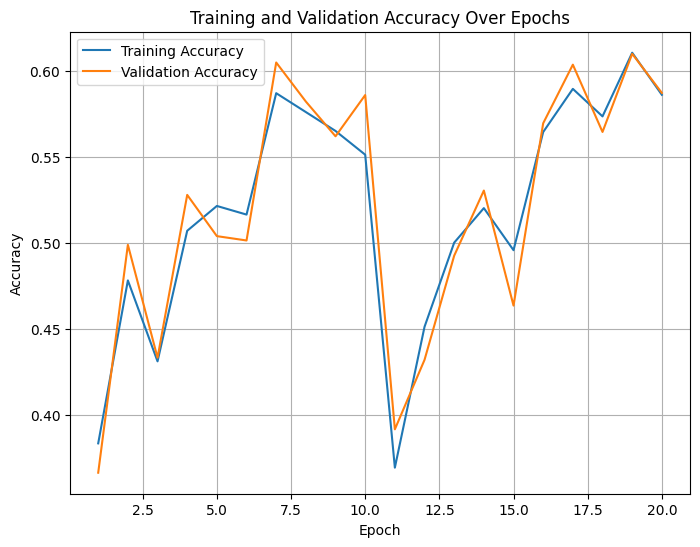

In [16]:
epochs = list(range(1, 20 + 1))
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_acc_list, label='Training Accuracy')
plt.plot(epochs, val_acc_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()



In [21]:
# Final evaluation on the validation set after training is completed
final_metrics = model.eval(dataset_val)
print("Final Validation Accuracy:", final_metrics)

Final Validation Accuracy: {'acc': 0.6073232323232324}


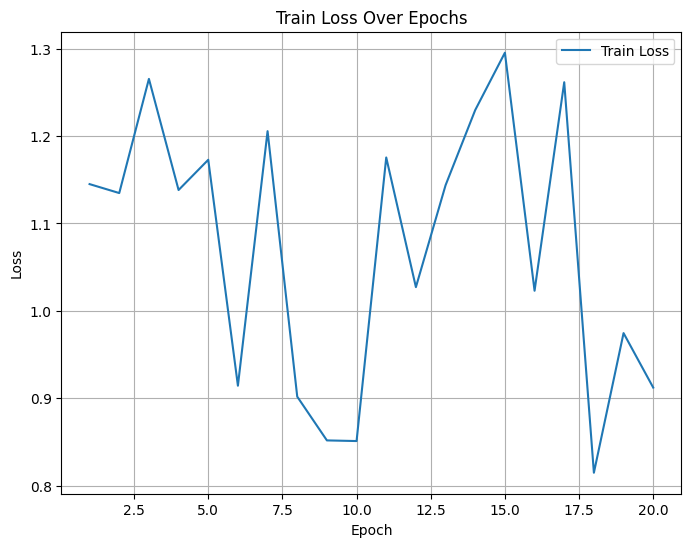

In [22]:
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss_list, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Model Testing

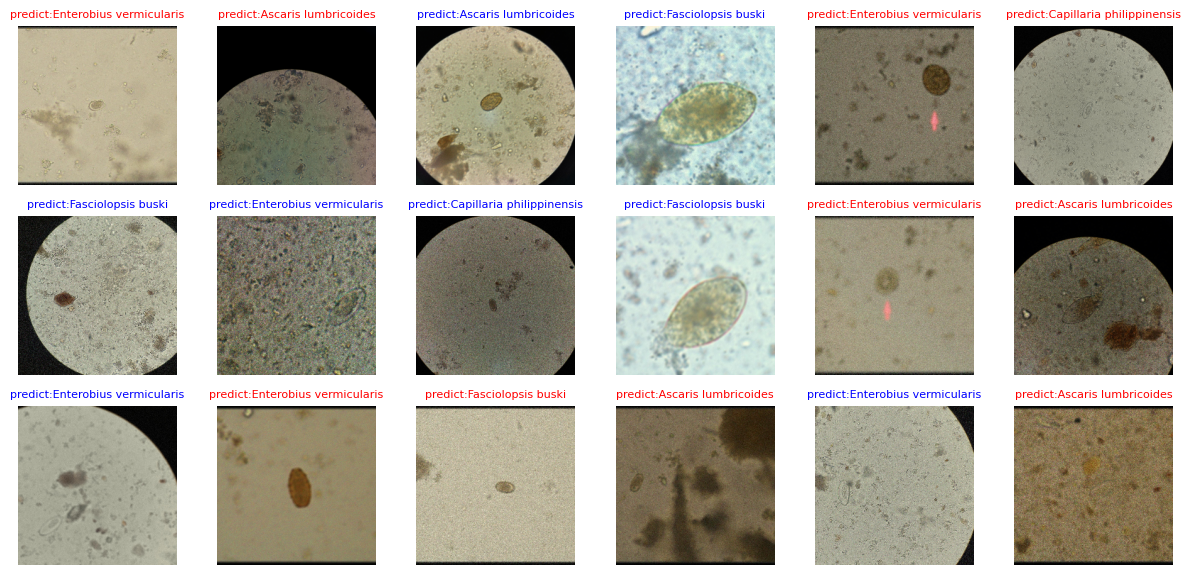

In [39]:
import matplotlib.pyplot as plt
import mindspore as ms

def visualize_model(best_ckpt_path, val_ds):
    net = resnet50(4)

    # Load model parameters.
    param_dict = ms.load_checkpoint(best_ckpt_path)
    ms.load_param_into_net(net, param_dict)
    model = ms.Model(net)

    # Load the validation dataset.
    data = next(val_ds.create_dict_iterator())
    images = data["image"].asnumpy()
    labels = data["label"].asnumpy()

    # Predict the image type.
    output = model.predict(ms.Tensor(data['image']))
    pred = np.argmax(output.asnumpy(), axis=1)

    # Display the image and the predicted value of the image.
    plt.figure(figsize=(15, 7))
    for i in range(len(labels)):
        plt.subplot(3, 6, i + 1)
    
        # If the prediction is correct, it is displayed in blue. If the prediction is incorrect, it is displayed in red.
        color = 'blue' if pred[i] == labels[i] else 'red'
        plt.title('predict:{}'.format(class_name[pred[i]]), color=color, fontdict={'size': 8})
        picture_show = np.transpose(images[i], (1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        picture_show = std * picture_show + mean
        picture_show = np.clip(picture_show, 0, 1)
        
        plt.imshow(picture_show)
        plt.axis('off')
    
    plt.show()

visualize_model('../models/model_resnet_2/resnet-ai-1-1_177.ckpt', dataset_val) 